# Mount

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# RAPIDS

In [2]:
import os, sys, io
import subprocess
from pathlib import Path

# Install RAPIDS -- we're doing this in one file, for now, due to ease of use
try:
  import pynvml
except:
  output = subprocess.Popen(["pip install pynvml"], shell=True, stderr=subprocess.STDOUT,
      stdout=subprocess.PIPE)
  for line in io.TextIOWrapper(output.stdout, encoding="utf-8"):
    if(line == ""):
      break
    else:
      print(line.rstrip())
  import pynvml
try:
  pynvml.nvmlInit()
except:
  raise Exception("""
                  Unfortunately you're in a Colab instance that doesn't have a GPU.

                  Please make sure you've configured Colab to request a GPU Instance Type.

                  Go to 'Runtime -> Change Runtime Type --> under the Hardware Accelerator, select GPU', then try again."""
  )
gpu_name = pynvml.nvmlDeviceGetName(pynvml.nvmlDeviceGetHandleByIndex(0))
rapids_version = "24.4.*"

if ('P' not in gpu_name):
  print('***********************************************************************')
  print('Woo! Your instance has a '+ str(gpu_name)+' GPU!')
  print(f'We will install the latest stable RAPIDS via pip {rapids_version}!  Please stand by, should be quick...')
  print('***********************************************************************')
  print()
else:
  print('***********************************************************************')
  print('Hey! Your instance has a Pascal GPU, a '+ str(gpu_name)+'!')
  print('We will install a compatible RAPIDS via pip (23.12)!  Please stand by, should be quick...')
  print('***********************************************************************')
  print()
  rapids_version = "23.12.*"


output = subprocess.Popen([f"pip install cudf-cu12=={rapids_version} cuml-cu12=={rapids_version} cugraph-cu12=={rapids_version} cuspatial-cu12=={rapids_version} cuproj-cu12=={rapids_version} cuxfilter-cu12=={rapids_version} cucim-cu12=={rapids_version} pylibraft-cu12=={rapids_version} raft-dask-cu12=={rapids_version} aiohttp --extra-index-url=https://pypi.nvidia.com"], shell=True, stderr=subprocess.STDOUT,
    stdout=subprocess.PIPE)
for line in io.TextIOWrapper(output.stdout, encoding="utf-8"):
  if(line == ""):
    break
  else:
    print(line.rstrip())
output = subprocess.Popen(["rm -rf /usr/local/lib/python3.10/dist-packages/cupy*"], shell=True, stderr=subprocess.STDOUT,
    stdout=subprocess.PIPE)
for line in io.TextIOWrapper(output.stdout, encoding="utf-8"):
  if(line == ""):
    break
  else:
    print(line.rstrip())
output = subprocess.Popen(["pip install cupy-cuda12x"], shell=True, stderr=subprocess.STDOUT,
    stdout=subprocess.PIPE)
for line in io.TextIOWrapper(output.stdout, encoding="utf-8"):
  if(line == ""):
    break
  else:
    print(line.rstrip())
print("""
        ***********************************************************************
        The pip install of RAPIDS is complete.

        Please do not run any further installation from the conda based installation methods, as they may cause issues!

        Please ensure that you're pulling from the git repo to remain updated with the latest working install scripts.

        Troubleshooting:
            - If there is an installation failure, please check back on RAPIDSAI owned templates/notebooks to see how to update your personal files.
            - If an installation failure persists when using the latest script, please make an issue on https://github.com/rapidsai-community/rapidsai-csp-utils
        ***********************************************************************
        """
      )

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.3 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has a NVIDIA L4 GPU!
We will install the latest stable RAPIDS via pip 24.4.*!  Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 GB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.8/137.8 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.9/920.9 kB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 94.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 MB 1.9 MB/s eta 0:00:00
     ━━━

#Linear SVM

## Linear SVM with Uni-grams

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import cudf
from cuml.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from cuml.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn_model_selection import KFold
import cupy as cp
import nltk
import numpy as np
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')
data = pd.read_csv('/content/drive/MyDrive/political_leaning_cleaned_dropped.csv')
X = data['clean_post']
y = data['political_leaning']
tfidf_vectorizer = TfidfVectorizer(max_features = 10000, stop_words=nltk_stopwords)
X_tfidf = tfidf_vectorizer.fit_transform(X)
X_tfidf_cudf = cudf.DataFrame(X_tfidf.toarray())
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_gpu = cp.array(y_encoded)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_cudf, y_gpu, test_size=0.2, random_state=42)

def cross_val_score_svm(model, X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    accuracy_scores = []
    f1_scores = []
    for train_index, test_index in kf.split(X.to_pandas().values):
        X_train_fold = X.iloc[train_index].to_cupy()
        X_test_fold = X.iloc[test_index].to_cupy()
        y_train_fold = y[train_index]
        y_test_fold = y[test_index]

        model.fit(X_train_fold.get(), y_train_fold.get())
        predictions = model.predict(X_test_fold.get())
        accuracy = accuracy_score(y_test_fold.get(), predictions)
        f1 = f1_score(y_test_fold.get(), predictions, average='weighted')

        accuracy_scores.append(accuracy)
        f1_scores.append(f1)

    return np.mean(accuracy_scores), np.mean(f1_scores)
svm_model = SVC(kernel='linear', C=1.0)
average_accuracy, average_f1 = cross_val_score_svm(svm_model, X_train, y_train, cv=5)
print(f'SVM with Linear Kernel and Unigrams: Average Accuracy={average_accuracy}, Average F1-score={average_f1}')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##Linear SVM with Bi Grams

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import cudf
from cuml.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from cuml.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn_model_selection import KFold
import cupy as cp
import nltk
import numpy as np
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')
data = pd.read_csv('/content/drive/MyDrive/political_leaning_cleaned_dropped.csv')
X = data['clean_post']
y = data['political_leaning']
tfidf_vectorizer = TfidfVectorizer(max_features = 10000, stop_words=nltk_stopwords, ngram_range=(2,2))
X_tfidf = tfidf_vectorizer.fit_transform(X)
X_tfidf_cudf = cudf.DataFrame(X_tfidf.toarray())
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_gpu = cp.array(y_encoded)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_cudf, y_gpu, test_size=0.2, random_state=42)

def cross_val_score_svm(model, X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    accuracy_scores = []
    f1_scores = []
    for train_index, test_index in kf.split(X.to_pandas().values):
        X_train_fold = X.iloc[train_index].to_cupy()
        X_test_fold = X.iloc[test_index].to_cupy()
        y_train_fold = y[train_index]
        y_test_fold = y[test_index]

        model.fit(X_train_fold.get(), y_train_fold.get())
        predictions = model.predict(X_test_fold.get())
        accuracy = accuracy_score(y_test_fold.get(), predictions)
        f1 = f1_score(y_test_fold.get(), predictions, average='weighted')

        accuracy_scores.append(accuracy)
        f1_scores.append(f1)

    return np.mean(accuracy_scores), np.mean(f1_scores)
svm_model = SVC(kernel='linear', C=1.0)
average_accuracy, average_f1 = cross_val_score_svm(svm_model, X_train, y_train, cv=5)
print(f'SVM with Linear Kernel and Unigrams: Average Accuracy={average_accuracy}, Average F1-score={average_f1}')


## Linear SVM with Tri-Grams

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import cudf
from cuml.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from cuml.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn_model_selection import KFold
import cupy as cp
import nltk
import numpy as np
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')
data = pd.read_csv('/content/drive/MyDrive/political_leaning_cleaned_dropped.csv')
X = data['clean_post']
y = data['political_leaning']
tfidf_vectorizer = TfidfVectorizer(max_features = 10000, stop_words=nltk_stopwords, ngram_range=(3,3))
X_tfidf = tfidf_vectorizer.fit_transform(X)
X_tfidf_cudf = cudf.DataFrame(X_tfidf.toarray())
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_gpu = cp.array(y_encoded)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_cudf, y_gpu, test_size=0.2, random_state=42)

def cross_val_score_svm(model, X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    accuracy_scores = []
    f1_scores = []
    for train_index, test_index in kf.split(X.to_pandas().values):
        X_train_fold = X.iloc[train_index].to_cupy()
        X_test_fold = X.iloc[test_index].to_cupy()
        y_train_fold = y[train_index]
        y_test_fold = y[test_index]

        model.fit(X_train_fold.get(), y_train_fold.get())
        predictions = model.predict(X_test_fold.get())
        accuracy = accuracy_score(y_test_fold.get(), predictions)
        f1 = f1_score(y_test_fold.get(), predictions, average='weighted')

        accuracy_scores.append(accuracy)
        f1_scores.append(f1)

    return np.mean(accuracy_scores), np.mean(f1_scores)
svm_model = SVC(kernel='linear', C=1.0)
average_accuracy, average_f1 = cross_val_score_svm(svm_model, X_train, y_train, cv=5)
print(f'SVM with Linear Kernel and Unigrams: Average Accuracy={average_accuracy}, Average F1-score={average_f1}')


## Linear SVM with Uni + Bi Grams

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import cudf
from cuml.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from cuml.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn_model_selection import KFold
import cupy as cp
import nltk
import numpy as np
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')
data = pd.read_csv('/content/drive/MyDrive/political_leaning_cleaned_dropped.csv')
X = data['clean_post']
y = data['political_leaning']
tfidf_vectorizer = TfidfVectorizer(max_features = 10000, stop_words=nltk_stopwords, ngram_range=(1,2))
X_tfidf = tfidf_vectorizer.fit_transform(X)
X_tfidf_cudf = cudf.DataFrame(X_tfidf.toarray())
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_gpu = cp.array(y_encoded)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_cudf, y_gpu, test_size=0.2, random_state=42)

def cross_val_score_svm(model, X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    accuracy_scores = []
    f1_scores = []
    for train_index, test_index in kf.split(X.to_pandas().values):
        X_train_fold = X.iloc[train_index].to_cupy()
        X_test_fold = X.iloc[test_index].to_cupy()
        y_train_fold = y[train_index]
        y_test_fold = y[test_index]

        model.fit(X_train_fold.get(), y_train_fold.get())
        predictions = model.predict(X_test_fold.get())
        accuracy = accuracy_score(y_test_fold.get(), predictions)
        f1 = f1_score(y_test_fold.get(), predictions, average='weighted')

        accuracy_scores.append(accuracy)
        f1_scores.append(f1)

    return np.mean(accuracy_scores), np.mean(f1_scores)
svm_model = SVC(kernel='linear', C=1.0)
average_accuracy, average_f1 = cross_val_score_svm(svm_model, X_train, y_train, cv=5)
print(f'SVM with Linear Kernel and Unigrams: Average Accuracy={average_accuracy}, Average F1-score={average_f1}')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Linear SVM with Uni+Bi+Tri Grams

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import cudf
from cuml.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from cuml.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn_model_selection import KFold
import cupy as cp
import nltk
import numpy as np
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')
data = pd.read_csv('/content/drive/MyDrive/political_leaning_cleaned_dropped.csv')
X = data['clean_post']
y = data['political_leaning']
tfidf_vectorizer = TfidfVectorizer(max_features = 10000, stop_words=nltk_stopwords, ngram_range=(1,3))
X_tfidf = tfidf_vectorizer.fit_transform(X)
X_tfidf_cudf = cudf.DataFrame(X_tfidf.toarray())
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_gpu = cp.array(y_encoded)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_cudf, y_gpu, test_size=0.2, random_state=42)

def cross_val_score_svm(model, X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    accuracy_scores = []
    f1_scores = []
    for train_index, test_index in kf.split(X.to_pandas().values):
        X_train_fold = X.iloc[train_index].to_cupy()
        X_test_fold = X.iloc[test_index].to_cupy()
        y_train_fold = y[train_index]
        y_test_fold = y[test_index]

        model.fit(X_train_fold.get(), y_train_fold.get())
        predictions = model.predict(X_test_fold.get())
        accuracy = accuracy_score(y_test_fold.get(), predictions)
        f1 = f1_score(y_test_fold.get(), predictions, average='weighted')

        accuracy_scores.append(accuracy)
        f1_scores.append(f1)

    return np.mean(accuracy_scores), np.mean(f1_scores)
svm_model = SVC(kernel='linear', C=1.0)
average_accuracy, average_f1 = cross_val_score_svm(svm_model, X_train, y_train, cv=5)
print(f'SVM with Linear Kernel and Unigrams: Average Accuracy={average_accuracy}, Average F1-score={average_f1}')


## HyperParam Tuning

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import cudf
from cuml.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from cuml.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn_model_selection import KFold
import cupy as cp
import nltk
import numpy as np
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')
data = pd.read_csv('/content/drive/MyDrive/political_leaning_cleaned_dropped.csv')
X = data['clean_post']
y = data['political_leaning']
tfidf_vectorizer = TfidfVectorizer(max_features = 10000, stop_words=nltk_stopwords, ngram_range=(3,3))
X_tfidf = tfidf_vectorizer.fit_transform(X)
X_tfidf_cudf = cudf.DataFrame(X_tfidf.toarray())
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_gpu = cp.array(y_encoded)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_cudf, y_gpu, test_size=0.2, random_state=42)

kf = KFold(n_splits=5, random_state=42, shuffle=True)

best_accuracy = 0
best_params = {}

for C in [0.1, 1.0, 10.0]:
    accuracies = []
    for train_index, test_index in kf.split(X_tfidf):
        X_train, X_test = X_tfidf.iloc[train_index], X_tfidf.iloc[test_index]
        y_train, y_test = y_gpu.iloc[train_index], y_gpu.iloc[test_index]

        svm_model = SVC(kernel='linear', C=C)
        svm_model.fit(X_train, y_train)

        predictions = svm_model.predict(X_test)
        acc = accuracy_score(y_test, predictions)
        accuracies.append(acc)

    avg_accuracy = np.mean(accuracies)
    print(f'Tested C={C}, Average Accuracy={avg_accuracy}')

    if avg_accuracy > best_accuracy:
        best_accuracy = avg_accuracy
        best_params = {'C': C}

print("Best parameters found: ", best_params)
print("Best accuracy: ", best_accuracy)

# RBF SVM

## RBF UNI Grams


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import cudf
from cuml.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from cuml.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn_model_selection import KFold
import cupy as cp
import nltk
import numpy as np
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')
data = pd.read_csv('/content/drive/MyDrive/political_leaning_cleaned_dropped.csv')
X = data['clean_post']
y = data['political_leaning']
tfidf_vectorizer = TfidfVectorizer(max_features = 10000, stop_words=nltk_stopwords)
X_tfidf = tfidf_vectorizer.fit_transform(X)
X_tfidf_cudf = cudf.DataFrame(X_tfidf.toarray())
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_gpu = cp.array(y_encoded)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_cudf, y_gpu, test_size=0.2, random_state=42)

def cross_val_score_svm(model, X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    accuracy_scores = []
    f1_scores = []
    for train_index, test_index in kf.split(X.to_pandas().values):
        X_train_fold = X.iloc[train_index].to_cupy()
        X_test_fold = X.iloc[test_index].to_cupy()
        y_train_fold = y[train_index]
        y_test_fold = y[test_index]

        model.fit(X_train_fold.get(), y_train_fold.get())
        predictions = model.predict(X_test_fold.get())
        accuracy = accuracy_score(y_test_fold.get(), predictions)
        f1 = f1_score(y_test_fold.get(), predictions, average='weighted')

        accuracy_scores.append(accuracy)
        f1_scores.append(f1)

    return np.mean(accuracy_scores), np.mean(f1_scores)
svm_model = SVC(kernel='rbf', C=1.0)
average_accuracy, average_f1 = cross_val_score_svm(svm_model, X_train, y_train, cv=5)
print(f'SVM with RBF Kernel and Unigrams: Average Accuracy={average_accuracy}, Average F1-score={average_f1}')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## RBF With only Bi-grams

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import cudf
from cuml.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from cuml.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn_model_selection import KFold
import cupy as cp
import nltk
import numpy as np
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')
data = pd.read_csv('/content/drive/MyDrive/political_leaning_cleaned_dropped.csv')
X = data['clean_post']
y = data['political_leaning']
tfidf_vectorizer = TfidfVectorizer(max_features = 10000, stop_words=nltk_stopwords, ngram_range=(2,2))
X_tfidf = tfidf_vectorizer.fit_transform(X)
X_tfidf_cudf = cudf.DataFrame(X_tfidf.toarray())
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_gpu = cp.array(y_encoded)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_cudf, y_gpu, test_size=0.2, random_state=42)

def cross_val_score_svm(model, X, y, cv=3):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    accuracy_scores = []
    f1_scores = []
    for train_index, test_index in kf.split(X.to_pandas().values):
        X_train_fold = X.iloc[train_index].to_cupy()
        X_test_fold = X.iloc[test_index].to_cupy()
        y_train_fold = y[train_index]
        y_test_fold = y[test_index]

        model.fit(X_train_fold.get(), y_train_fold.get())
        predictions = model.predict(X_test_fold.get())
        accuracy = accuracy_score(y_test_fold.get(), predictions)
        f1 = f1_score(y_test_fold.get(), predictions, average='weighted')

        accuracy_scores.append(accuracy)
        f1_scores.append(f1)

    return np.mean(accuracy_scores), np.mean(f1_scores)
svm_model = SVC(kernel='rbf', C=1.0)
average_accuracy, average_f1 = cross_val_score_svm(svm_model, X_train, y_train, cv=3)
print(f'SVM with RBF Kernel and Bigrams: Average Accuracy={average_accuracy}, Average F1-score={average_f1}')


## RBF with Tri Grams

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import cudf
from cuml.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from cuml.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn_model_selection import KFold
import cupy as cp
import nltk
import numpy as np
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')
data = pd.read_csv('/content/drive/MyDrive/political_leaning_cleaned_dropped.csv')
X = data['clean_post']
y = data['political_leaning']
tfidf_vectorizer = TfidfVectorizer(max_features = 10000, stop_words=nltk_stopwords, ngram_range=(3,3))
X_tfidf = tfidf_vectorizer.fit_transform(X)
X_tfidf_cudf = cudf.DataFrame(X_tfidf.toarray())
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_gpu = cp.array(y_encoded)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_cudf, y_gpu, test_size=0.2, random_state=42)

def cross_val_score_svm(model, X, y, cv=3):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    accuracy_scores = []
    f1_scores = []
    for train_index, test_index in kf.split(X.to_pandas().values):
        X_train_fold = X.iloc[train_index].to_cupy()
        X_test_fold = X.iloc[test_index].to_cupy()
        y_train_fold = y[train_index]
        y_test_fold = y[test_index]

        model.fit(X_train_fold.get(), y_train_fold.get())
        predictions = model.predict(X_test_fold.get())
        accuracy = accuracy_score(y_test_fold.get(), predictions)
        f1 = f1_score(y_test_fold.get(), predictions, average='weighted')

        accuracy_scores.append(accuracy)
        f1_scores.append(f1)

    return np.mean(accuracy_scores), np.mean(f1_scores)
svm_model = SVC(kernel='rbf', C=1.0)
average_accuracy, average_f1 = cross_val_score_svm(svm_model, X_train, y_train, cv=3)
print(f'SVM with RBF Kernel and Trigrams: Average Accuracy={average_accuracy}, Average F1-score={average_f1}')


## RBF UNI + Bi Grams

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import cudf
from cuml.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from cuml.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn_model_selection import KFold
import cupy as cp
import nltk
import numpy as np
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')
data = pd.read_csv('/content/drive/MyDrive/political_leaning_cleaned_dropped.csv')
X = data['clean_post']
y = data['political_leaning']
tfidf_vectorizer = TfidfVectorizer(max_features = 10000, stop_words=nltk_stopwords, ngram_range=(1,2))
X_tfidf = tfidf_vectorizer.fit_transform(X)
X_tfidf_cudf = cudf.DataFrame(X_tfidf.toarray())
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_gpu = cp.array(y_encoded)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_cudf, y_gpu, test_size=0.2, random_state=42)

def cross_val_score_svm(model, X, y, cv=3):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    accuracy_scores = []
    f1_scores = []
    for train_index, test_index in kf.split(X.to_pandas().values):
        X_train_fold = X.iloc[train_index].to_cupy()
        X_test_fold = X.iloc[test_index].to_cupy()
        y_train_fold = y[train_index]
        y_test_fold = y[test_index]

        model.fit(X_train_fold.get(), y_train_fold.get())
        predictions = model.predict(X_test_fold.get())
        accuracy = accuracy_score(y_test_fold.get(), predictions)
        f1 = f1_score(y_test_fold.get(), predictions, average='weighted')

        accuracy_scores.append(accuracy)
        f1_scores.append(f1)

    return np.mean(accuracy_scores), np.mean(f1_scores)
svm_model = SVC(kernel='rbf', C=1.0)
average_accuracy, average_f1 = cross_val_score_svm(svm_model, X_train, y_train, cv=3)
print(f'SVM with RBF Kernel and Uni+Bigrams: Average Accuracy={average_accuracy}, Average F1-score={average_f1}')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##RBF With Uni + Bi+  Tri-Grams

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import cudf
from cuml.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from cuml.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn_model_selection import KFold
import cupy as cp
import nltk
import numpy as np
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')
data = pd.read_csv('/content/drive/MyDrive/political_leaning_cleaned_dropped.csv')
X = data['clean_post']
y = data['political_leaning']
tfidf_vectorizer = TfidfVectorizer(max_features = 10000, stop_words=nltk_stopwords, ngram_range=(1,3))
X_tfidf = tfidf_vectorizer.fit_transform(X)
X_tfidf_cudf = cudf.DataFrame(X_tfidf.toarray())
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_gpu = cp.array(y_encoded)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_cudf, y_gpu, test_size=0.2, random_state=42)

def cross_val_score_svm(model, X, y, cv=3):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    accuracy_scores = []
    f1_scores = []
    for train_index, test_index in kf.split(X.to_pandas().values):
        X_train_fold = X.iloc[train_index].to_cupy()
        X_test_fold = X.iloc[test_index].to_cupy()
        y_train_fold = y[train_index]
        y_test_fold = y[test_index]

        model.fit(X_train_fold.get(), y_train_fold.get())
        predictions = model.predict(X_test_fold.get())
        accuracy = accuracy_score(y_test_fold.get(), predictions)
        f1 = f1_score(y_test_fold.get(), predictions, average='weighted')

        accuracy_scores.append(accuracy)
        f1_scores.append(f1)

    return np.mean(accuracy_scores), np.mean(f1_scores)
svm_model = SVC(kernel='rbf', C=1.0)
average_accuracy, average_f1 = cross_val_score_svm(svm_model, X_train, y_train, cv=3)
print(f'SVM with RBF Kernel and Uni+Bi+Trigrams: Average Accuracy={average_accuracy}, Average F1-score={average_f1}')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## RBF Hyperparameter Tuning

In [ ]:
import pandas as pd
import cudf
from cuml.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from cuml.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import cupy as cp
from sklearn.preprocessing import LabelEncoder
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')
data = pd.read_csv('/content/drive/MyDrive/political_leaning_cleaned_dropped.csv')
X = data['clean_post']
y = data['political_leaning']
tfidf_vectorizer = TfidfVectorizer(max_features = 10000, stop_words = nltk_stopwords)  # You can adjust parameters
X_tfidf = tfidf_vectorizer.fit_transform(X)
X_tfidf_cudf = cudf.DataFrame(X_tfidf.toarray())
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_gpu = cp.array(y_encoded)
kf = KFold(n_splits=5, random_state=42, shuffle=True)

best_accuracy = 0
best_params = {}

param_grid_C = [0.1, 1, 10, 100]
param_grid_gamma = [1, 0.1, 0.01, 0.001]
for C in param_grid_C:
    for gamma in param_grid_gamma:
        accuracies = []
        for train_index, test_index in kf.split(X_tfidf_cudf):
            X_train, X_test = X_tfidf_cudf.iloc[train_index].to_cupy(), X_tfidf_cudf.iloc[test_index].to_cupy()
            y_train, y_test = y_gpu[train_index], y_gpu[test_index]

            svm_model = SVC(kernel='rbf', C=C, gamma=gamma)
            svm_model.fit(X_train, y_train)

            predictions = svm_model.predict(X_test)
            acc = accuracy_score(y_test.get(), predictions.get())
            accuracies.append(acc)

        avg_accuracy = np.mean(accuracies)
        print(f'Tested C={C}, gamma={gamma}, Average Accuracy={avg_accuracy}')

        if avg_accuracy > best_accuracy:
            best_accuracy = avg_accuracy
            best_params = {'C': C, 'gamma': gamma}
print("Best parameters found: ", best_params)
print("Best accuracy: ", best_accuracy)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_cudf.to_cupy(), y_gpu, test_size=0.2, random_state=42)
best_svm = SVC(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'])
best_svm.fit(X_train, y_train)
predictions = best_svm.predict(X_test)
accuracy = accuracy_score(y_test.get(), predictions.get())
print(f'Test set accuracy: {accuracy}')

## Best SVM Model:
Kernel = RBF
C = 10.0
Gamma = 1.0

In [ ]:
predictions = svm_model.predict(X_test)
predictions_np = cp.asnumpy(predictions)
y_test_np = cp.asnumpy(y_test)
print("Accuracy:", cuml_accuracy_score(y_test, predictions))
print("Classification Report:\n", classification_report(y_test_np, predictions_np, target_names=label_encoder.classes_))


In [ ]:
from sklearn.metrics import accuracy_score as sklearn_accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
predictions_np = cp.asnumpy(predictions)
y_test_np = cp.asnumpy(y_test)
conf_matrix = confusion_matrix(y_test_np, predictions_np)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for optimal SVM')
plt.show()
print("Accuracy:", sklearn_accuracy_score(y_test_np, predictions_np))
print("Classification Report:\n", classification_report(y_test_np, predictions_np, target_names=label_encoder.classes_))

# Logistic Regression

## LR **Uni**

In [ ]:
import pandas as pd
import cudf
from cuml.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from cuml.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score
import cupy as cp
from sklearn.preprocessing import LabelEncoder
import numpy as np
import nltk
from nltk.corpus import stopwords
from cuml.linear_model import LogisticRegression as cuLogisticRegression
from sklearn.model_selection import KFold

nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')
data = pd.read_csv('/content/drive/MyDrive/political_leaning_cleaned_dropped.csv')
X = data['clean_post']
y = data['political_leaning']
tfidf_vectorizer = TfidfVectorizer(max_features = 10000, stop_words = nltk_stopwords)
X_tfidf = tfidf_vectorizer.fit_transform(X)
X_tfidf_cudf = cudf.DataFrame(X_tfidf.toarray())
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_gpu = cp.array(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf_cudf, y_gpu, test_size=0.2, random_state=42)
ef cross_val_score(model, X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    accuracy_scores = []
    f1_scores = []
    for train_index, test_index in kf.split(X.to_pandas().values):
        X_train_fold = X.iloc[train_index].to_cupy()
        X_test_fold = X.iloc[test_index].to_cupy()
        y_train_fold = y[train_index]
        y_test_fold = y[test_index]

        model.fit(X_train_fold.get(), y_train_fold.get())
        predictions = model.predict(X_test_fold.get())

        accuracy = accuracy_score(y_test_fold.get(), predictions)
        f1 = f1_score(y_test_fold.get(), predictions, average='weighted')

        accuracy_scores.append(accuracy)
        f1_scores.append(f1)

    return np.mean(accuracy_scores), np.mean(f1_scores)
lr_model = cuLogisticRegression()
average_accuracy, average_f1 = cross_val_score(lr_model, X_train, y_train, cv=5)
print(f'Logistic Regression with Unigrams: Average Accuracy={average_accuracy}, Average F1-score={average_f1}')


## LR with Bi-grams

In [9]:
import pandas as pd
import cudf
from cuml.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from cuml.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score
import cupy as cp
from sklearn.preprocessing import LabelEncoder
import numpy as np
import nltk
from nltk.corpus import stopwords
from cuml.linear_model import LogisticRegression as cuLogisticRegression
from sklearn.model_selection import KFold

nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')
data = pd.read_csv('/content/drive/MyDrive/political_leaning_cleaned_dropped.csv')
X = data['clean_post']
y = data['political_leaning']
tfidf_vectorizer = TfidfVectorizer(max_features = 10000, stop_words = nltk_stopwords, ngram_range = (2,2))
X_tfidf = tfidf_vectorizer.fit_transform(X)
X_tfidf_cudf = cudf.DataFrame(X_tfidf.toarray())
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_gpu = cp.array(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf_cudf, y_gpu, test_size=0.2, random_state=42)
ef cross_val_score(model, X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    accuracy_scores = []
    f1_scores = []
    for train_index, test_index in kf.split(X.to_pandas().values):
        X_train_fold = X.iloc[train_index].to_cupy()
        X_test_fold = X.iloc[test_index].to_cupy()
        y_train_fold = y[train_index]
        y_test_fold = y[test_index]

        model.fit(X_train_fold.get(), y_train_fold.get())
        predictions = model.predict(X_test_fold.get())

        accuracy = accuracy_score(y_test_fold.get(), predictions)
        f1 = f1_score(y_test_fold.get(), predictions, average='weighted')

        accuracy_scores.append(accuracy)
        f1_scores.append(f1)

    return np.mean(accuracy_scores), np.mean(f1_scores)
lr_model = cuLogisticRegression()
average_accuracy, average_f1 = cross_val_score(lr_model, X_train, y_train, cv=5)
print(f'Logistic Regression with Unigrams: Average Accuracy={average_accuracy}, Average F1-score={average_f1}')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## LR uni + bi grams


In [ ]:
import pandas as pd
import cudf
from cuml.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from cuml.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score
import cupy as cp
from sklearn.preprocessing import LabelEncoder
import numpy as np
import nltk
from nltk.corpus import stopwords
from cuml.linear_model import LogisticRegression as cuLogisticRegression
from sklearn.model_selection import KFold

nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')
data = pd.read_csv('/content/drive/MyDrive/political_leaning_cleaned_dropped.csv')
X = data['clean_post']
y = data['political_leaning']
tfidf_vectorizer = TfidfVectorizer(max_features = 10000, stop_words = nltk_stopwords, ngram_range = (1,2))
X_tfidf = tfidf_vectorizer.fit_transform(X)
X_tfidf_cudf = cudf.DataFrame(X_tfidf.toarray())
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_gpu = cp.array(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf_cudf, y_gpu, test_size=0.2, random_state=42)
ef cross_val_score(model, X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    accuracy_scores = []
    f1_scores = []
    for train_index, test_index in kf.split(X.to_pandas().values):
        X_train_fold = X.iloc[train_index].to_cupy()
        X_test_fold = X.iloc[test_index].to_cupy()
        y_train_fold = y[train_index]
        y_test_fold = y[test_index]

        model.fit(X_train_fold.get(), y_train_fold.get())
        predictions = model.predict(X_test_fold.get())

        accuracy = accuracy_score(y_test_fold.get(), predictions)
        f1 = f1_score(y_test_fold.get(), predictions, average='weighted')

        accuracy_scores.append(accuracy)
        f1_scores.append(f1)

    return np.mean(accuracy_scores), np.mean(f1_scores)
lr_model = cuLogisticRegression()
average_accuracy, average_f1 = cross_val_score(lr_model, X_train, y_train, cv=5)
print(f'Logistic Regression with Unigrams: Average Accuracy={average_accuracy}, Average F1-score={average_f1}')


##LR with Tri-grams

In [ ]:
import pandas as pd
import cudf
from cuml.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from cuml.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score
import cupy as cp
from sklearn.preprocessing import LabelEncoder
import numpy as np
import nltk
from nltk.corpus import stopwords
from cuml.linear_model import LogisticRegression as cuLogisticRegression
from sklearn.model_selection import KFold

nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')
data = pd.read_csv('/content/drive/MyDrive/political_leaning_cleaned_dropped.csv')
X = data['clean_post']
y = data['political_leaning']
tfidf_vectorizer = TfidfVectorizer(max_features = 10000, stop_words = nltk_stopwords, ngram_range = (3,3))
X_tfidf = tfidf_vectorizer.fit_transform(X)
X_tfidf_cudf = cudf.DataFrame(X_tfidf.toarray())
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_gpu = cp.array(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf_cudf, y_gpu, test_size=0.2, random_state=42)
ef cross_val_score(model, X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    accuracy_scores = []
    f1_scores = []
    for train_index, test_index in kf.split(X.to_pandas().values):
        X_train_fold = X.iloc[train_index].to_cupy()
        X_test_fold = X.iloc[test_index].to_cupy()
        y_train_fold = y[train_index]
        y_test_fold = y[test_index]

        model.fit(X_train_fold.get(), y_train_fold.get())
        predictions = model.predict(X_test_fold.get())

        accuracy = accuracy_score(y_test_fold.get(), predictions)
        f1 = f1_score(y_test_fold.get(), predictions, average='weighted')

        accuracy_scores.append(accuracy)
        f1_scores.append(f1)

    return np.mean(accuracy_scores), np.mean(f1_scores)
lr_model = cuLogisticRegression()
average_accuracy, average_f1 = cross_val_score(lr_model, X_train, y_train, cv=5)
print(f'Logistic Regression with Unigrams: Average Accuracy={average_accuracy}, Average F1-score={average_f1}')


## LR with Uni + Bi + Tri grams

In [7]:
import pandas as pd
import cudf
from cuml.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from cuml.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score
import cupy as cp
from sklearn.preprocessing import LabelEncoder
import numpy as np
import nltk
from nltk.corpus import stopwords
from cuml.linear_model import LogisticRegression as cuLogisticRegression
from sklearn.model_selection import KFold

nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')
data = pd.read_csv('/content/drive/MyDrive/political_leaning_cleaned_dropped.csv')
X = data['clean_post']
y = data['political_leaning']
tfidf_vectorizer = TfidfVectorizer(max_features = 10000, stop_words = nltk_stopwords, ngram_range = (1,3))
X_tfidf = tfidf_vectorizer.fit_transform(X)
X_tfidf_cudf = cudf.DataFrame(X_tfidf.toarray())
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_gpu = cp.array(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf_cudf, y_gpu, test_size=0.2, random_state=42)
ef cross_val_score(model, X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    accuracy_scores = []
    f1_scores = []
    for train_index, test_index in kf.split(X.to_pandas().values):
        X_train_fold = X.iloc[train_index].to_cupy()
        X_test_fold = X.iloc[test_index].to_cupy()
        y_train_fold = y[train_index]
        y_test_fold = y[test_index]

        model.fit(X_train_fold.get(), y_train_fold.get())
        predictions = model.predict(X_test_fold.get())

        accuracy = accuracy_score(y_test_fold.get(), predictions)
        f1 = f1_score(y_test_fold.get(), predictions, average='weighted')

        accuracy_scores.append(accuracy)
        f1_scores.append(f1)

    return np.mean(accuracy_scores), np.mean(f1_scores)
lr_model = cuLogisticRegression()
average_accuracy, average_f1 = cross_val_score(lr_model, X_train, y_train, cv=5)
print(f'Logistic Regression with Unigrams: Average Accuracy={average_accuracy}, Average F1-score={average_f1}')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## LR HyperParameter Tuning

In [ ]:
import pandas as pd
import cudf
from cuml.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from cuml.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import cupy as cp
from sklearn.preprocessing import LabelEncoder
import numpy as np
import nltk
from nltk.corpus import stopwords
from cuml.linear_model import LogisticRegression as cuLogisticRegression
from sklearn.model_selection import KFold
from cuml.metrics import accuracy_score
nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')
data = pd.read_csv('/content/drive/MyDrive/political_leaning_cleaned_dropped.csv')
X = data['clean_post']
y = data['political_leaning']

tfidf_vectorizer = TfidfVectorizer(max_features = 10000, stop_words = nltk_stopwords)
X_tfidf = tfidf_vectorizer.fit_transform(X)

X_tfidf_cudf = cudf.DataFrame(X_tfidf.toarray())
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_gpu = cp.array(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf_cudf, y_gpu, test_size=0.2, random_state=42)


kf = KFold(n_splits=5, random_state=42, shuffle=True)

best_accuracy = 0
best_params = {}

param_grid_C = [0.01, 0.1, 1, 10, 100]
param_grid_penalty = ['l1', 'l2']

for C in param_grid_C:
    for penalty in param_grid_penalty:
        accuracies = []
        for train_index, test_index in kf.split(X_tfidf_cudf):
            X_train, X_test = X_tfidf_cudf.iloc[train_index].to_cupy(), X_tfidf_cudf.iloc[test_index].to_cupy()
            y_train, y_test = y_gpu[train_index], y_gpu[test_index]

            lr_model = cuLogisticRegression(C=C, penalty=penalty)
            lr_model.fit(X_train, y_train)

            predictions = lr_model.predict(X_test)
            acc = accuracy_score(y_test.get(), predictions.get())
            accuracies.append(acc)

        avg_accuracy = np.mean(accuracies)
        print(f'Tested C={C}, penalty={penalty}, Average Accuracy={avg_accuracy}')

        if avg_accuracy > best_accuracy:
            best_accuracy = avg_accuracy
            best_params = {'C': C, 'penalty': penalty}

print("Best parameters found: ", best_params)
print("Best accuracy: ", best_accuracy)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf_cudf.to_cupy(), y_gpu, test_size=0.2, random_state=42)

best_lr = cuLogisticRegression(C=best_params['C'], penalty=best_params['penalty'])
best_lr.fit(X_train, y_train)

predictions = best_lr.predict(X_test)
accuracy = accuracy_score(y_test.get(), predictions.get())
print(f'Test set accuracy: {accuracy}')



In [ ]:
from sklearn.metrics import accuracy_score as sklearn_accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions_np = cp.asnumpy(predictions)
y_test_np = cp.asnumpy(y_test)

conf_matrix = confusion_matrix(y_test_np, predictions_np)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

print("Accuracy:", sklearn_accuracy_score(y_test_np, predictions_np))
print("Classification Report:\n", classification_report(y_test_np, predictions_np, target_names=label_encoder.classes_))

# Feature Analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

class_labels = label_encoder.classes_
coefficients = best_lr.coef_.to_numpy() y

feature_names = tfidf_vectorizer.get_feature_names_out()

num_classes = coefficients.shape[0]
for class_index in range(num_classes):
    class_coefficients = coefficients[class_index]
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': class_coefficients
    })
    feature_importance_df['Absolute_Coefficient'] = feature_importance_df['Coefficient'].abs()
    feature_importance_df = feature_importance_df.sort_values(by='Absolute_Coefficient', ascending=False)
    print(f"Top 10 features for class {class_labels[class_index]}:")
    print(feature_importance_df.head(10))
    top_n = 20
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance_df['Feature'].head(top_n), feature_importance_df['Coefficient'].head(top_n))
    plt.xlabel('Coefficient')
    plt.title(f'Top 20 Features Importance for Class {class_labels[class_index]}')
    plt.gca().invert_yaxis()
    plt.show()

#SMOTE

In [ ]:
!pip install smote

## Logistic Regression

In [ ]:
import pandas as pd
import cupy as cp
import cudf
from cuml.feature_extraction.text import TfidfVectorizer
from cuml.linear_model import LogisticRegression as cuLogisticRegression
from sklearn.model_selection import train_test_split, KFold
from cuml.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')

data = pd.read_csv('/content/drive/MyDrive/political_leaning_cleaned_dropped.csv')
X = data['clean_post']
y = data['political_leaning']

tfidf_vectorizer = TfidfVectorizer(max_features=10000,stop_words= nltk_stopwords)
X_tfidf = tfidf_vectorizer.fit_transform(X)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)





In [ ]:
import numpy as np

X_dense = X_tfidf.toarray().get()


smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_dense, y_encoded)



In [ ]:
X_resampled_cudf = cudf.DataFrame(X_resampled)
y_resampled_gpu = cp.array(y_resampled)


kf = KFold(n_splits=5, random_state=42, shuffle=True)

best_accuracy = 0
best_params = {}

param_grid_C = [0.01, 0.1, 1, 10, 100]
penalty_options = ['l1','l2']

for C in param_grid_C:
    for penalty in penalty_options:
        accuracies = []
        for train_index, test_index in kf.split(X_resampled_cudf):
            X_train, X_test = X_resampled_cudf.iloc[train_index].to_cupy(), X_resampled_cudf.iloc[test_index].to_cupy()
            y_train, y_test = y_resampled_gpu[train_index], y_resampled_gpu[test_index]

            lr_model = cuLogisticRegression(penalty=penalty, C=C)
            lr_model.fit(X_train, y_train)

            predictions = lr_model.predict(X_test)
            acc = accuracy_score(y_test.get(), predictions.get())
            accuracies.append(acc)

        avg_accuracy = np.mean(accuracies)
        print(f'Tested C={C}, penalty={penalty}, Average Accuracy={avg_accuracy}')

        if avg_accuracy > best_accuracy:
            best_accuracy = avg_accuracy
            best_params = {'C': C, 'penalty': penalty}

print("Best parameters found: ", best_params)
print("Best accuracy: ", best_accuracy)

X_train, X_test, y_train, y_test = train_test_split(X_resampled_cudf.to_cupy(), y_resampled_gpu, test_size=0.2, random_state=42)

best_lr = cuLogisticRegression(penalty=best_params['penalty'], C=best_params['C'])
best_lr.fit(X_train, y_train)

predictions = best_lr.predict(X_test)
accuracy = accuracy_score(y_test.get(), predictions.get())
print(f'Test set accuracy: {accuracy}')

from sklearn.metrics import classification_report

In [ ]:
print("Classification Report:\n", classification_report(y_test.get(), predictions.get(), target_names=label_encoder.classes_))


In [ ]:
from sklearn.metrics import accuracy_score as sklearn_accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions_np = cp.asnumpy(predictions)
y_test_np = cp.asnumpy(y_test)

conf_matrix = confusion_matrix(y_test_np, predictions_np)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for LR with SMOTE')
plt.show()

print("Accuracy:", sklearn_accuracy_score(y_test_np, predictions_np))
print("Classification Report:\n", classification_report(y_test_np, predictions_np, target_names=label_encoder.classes_))

## RBF SVM with SMOTE

In [ ]:
from cuml.svm import SVC

kf = KFold(n_splits=5, random_state=42, shuffle=True)

best_accuracy = 0
best_params = {}

param_grid_C = [0.1, 1, 10, 100]
param_grid_gamma = [1, 0.1, 0.01, 0.001]

for C in param_grid_C:
    for gamma in param_grid_gamma:
        accuracies = []
        for train_index, test_index in kf.split(X_resampled_cudf):
            X_train, X_test = X_resampled_cudf.iloc[train_index].to_cupy(), X_resampled_cudf.iloc[test_index].to_cupy()
            y_train, y_test = y_resampled_gpu[train_index], y_resampled_gpu[test_index]

            svm_model = SVC(kernel='rbf', C=C, gamma=gamma)
            svm_model.fit(X_train, y_train)

            predictions = svm_model.predict(X_test)
            acc = accuracy_score(y_test.get(), predictions.get())
            accuracies.append(acc)

        avg_accuracy = np.mean(accuracies)
        print(f'Tested C={C}, gamma={gamma}, Average Accuracy={avg_accuracy}')

        if avg_accuracy > best_accuracy:
            best_accuracy = avg_accuracy
            best_params = {'C': C, 'gamma': gamma}

print("Best parameters found: ", best_params)
print("Best accuracy: ", best_accuracy)

X_train, X_test, y_train, y_test = train_test_split(X_resampled_cudf.to_cupy(), y_resampled_gpu, test_size=0.2, random_state=42)

best_svm = SVC(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'])
best_svm.fit(X_train, y_train)

predictions = best_svm.predict(X_test)
accuracy = accuracy_score(y_test.get(), predictions.get())
print(f'Test set accuracy: {accuracy}')

print("Classification Report:\n", classification_report(y_test.get(), predictions.get(), target_names=label_encoder.classes_))

In [ ]:
from sklearn.metrics import accuracy_score as sklearn_accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions_np = cp.asnumpy(predictions)
y_test_np = cp.asnumpy(y_test)

conf_matrix = confusion_matrix(y_test_np, predictions_np)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for RBF SVM with SMOTE')
plt.show()

print("Accuracy:", sklearn_accuracy_score(y_test_np, predictions_np))
print("Classification Report:\n", classification_report(y_test_np, predictions_np, target_names=label_encoder.classes_))

#BERT

### Install Packages

In [1]:
!pip install datasets transformers[torch] accelerate -U


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 25.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (4

## imbalanced

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset, load_from_disk
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, AdamW, EarlyStoppingCallback
import numpy as np
from sklearn.metrics import accuracy_score

train_dataset = load_from_disk('/content/drive/MyDrive/train_dataset')
test_dataset = load_from_disk('/content/drive/MyDrive/test_dataset')

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define a function to compute accuracy
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
    }

# Define a custom optimizer function to set Adam beta parameters
def custom_optimizer(model):
    return AdamW(model.parameters(), lr=5e-5, betas=(0.9, 0.999), weight_decay=0.01)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_steps=10_000,
    save_total_limit=2,
    load_best_model_at_end=True,
    warmup_steps=10000
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    optimizers=(custom_optimizer(model), None),
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    compute_metrics=compute_metrics,
)

# Function to print accuracy for each epoch
def print_epoch_accuracies(trainer):
    logs = trainer.state.log_history
    for log in logs:
        if 'eval_accuracy' in log:
            print(f"Epoch {log['epoch']}: Accuracy {log['eval_accuracy']}")

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(results)

# Predict and print the classification report
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(-1)



In [ ]:
# Print classification report
from sklearn.metrics import classification_report
data = pd.read_csv('/content/drive/MyDrive/political_leaning_cleaned_dropped.csv')

X = data['clean_post']
y = data['political_leaning']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
print(classification_report(y_test, pred_labels, target_names=label_encoder.classes_))


In [ ]:
import matplotlib.pyplot as plt


training_logs = trainer.state.log_history
train_loss = [entry['loss'] for entry in training_logs if 'loss' in entry]
val_loss = [entry['eval_loss'] for entry in training_logs if 'eval_loss' in entry]

min_length = min(len(train_loss), len(val_loss))
train_loss = train_loss[:min_length]
val_loss = val_loss[:min_length]

epochs = range(1, min_length + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.ylim(0, 1.5)
plt.legend()
plt.grid(True)
plt.savefig('loss_curves.png')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

true_labels = test_dataset['label']

cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save_pretrained('/content/drive/MyDrive/fine-tuned-bert')
tokenizer.save_pretrained('/content/drive/MyDrive/fine-tuned-bert')


## Weigt balancing BERT

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset, load_from_disk
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, AdamW, EarlyStoppingCallback
import numpy as np
import torch
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report

data = pd.read_csv('/content/drive/MyDrive/political_leaning_cleaned_dropped.csv')
X = data['clean_post']
y = data['political_leaning']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = load_from_disk('/content/drive/MyDrive/train_dataset')
test_dataset = load_from_disk('/content/drive/MyDrive/test_dataset')


# Load BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Define a function to compute metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc}

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_steps=10_000,
    save_total_limit=2,
    load_best_model_at_end=True,
    warmup_steps=10000
)

# Trainer with class weights
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(results)

# Predict and print the classification report
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(-1)

print(classification_report(y_test, pred_labels, target_names=label_encoder.classes_))


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.998800,0.925922,0.528830
2,0.857700,0.874450,0.608613
3,0.689200,0.951137,0.568631
4,0.601400,0.894269,0.615775


{'eval_loss': 0.8744496703147888, 'eval_accuracy': 0.6086128739800544, 'eval_runtime': 107.9245, 'eval_samples_per_second': 102.201, 'eval_steps_per_second': 6.393, 'epoch': 4.0}
              precision    recall  f1-score   support

      center       0.61      0.71      0.66      4919
        left       0.60      0.48      0.53      2722
       right       0.60      0.56      0.58      3389

    accuracy                           0.61     11030
   macro avg       0.61      0.58      0.59     11030
weighted avg       0.61      0.61      0.60     11030



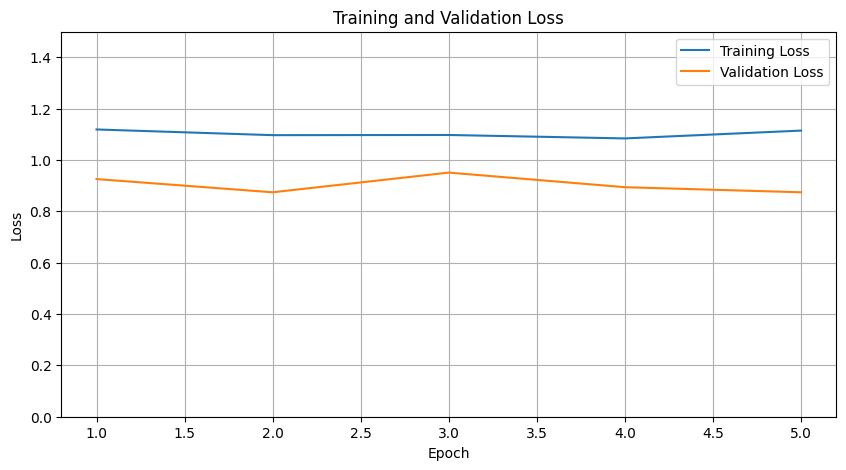

In [7]:
import matplotlib.pyplot as plt
training_logs = trainer.state.log_history
train_loss = [entry['loss'] for entry in training_logs if 'loss' in entry]
val_loss = [entry['eval_loss'] for entry in training_logs if 'eval_loss' in entry]
min_length = min(len(train_loss), len(val_loss))
train_loss = train_loss[:min_length]
val_loss = val_loss[:min_length]
epochs = range(1, min_length + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.ylim(0, 1.5)
plt.legend()
plt.grid(True)
plt.savefig('loss_curves.png')
plt.show()


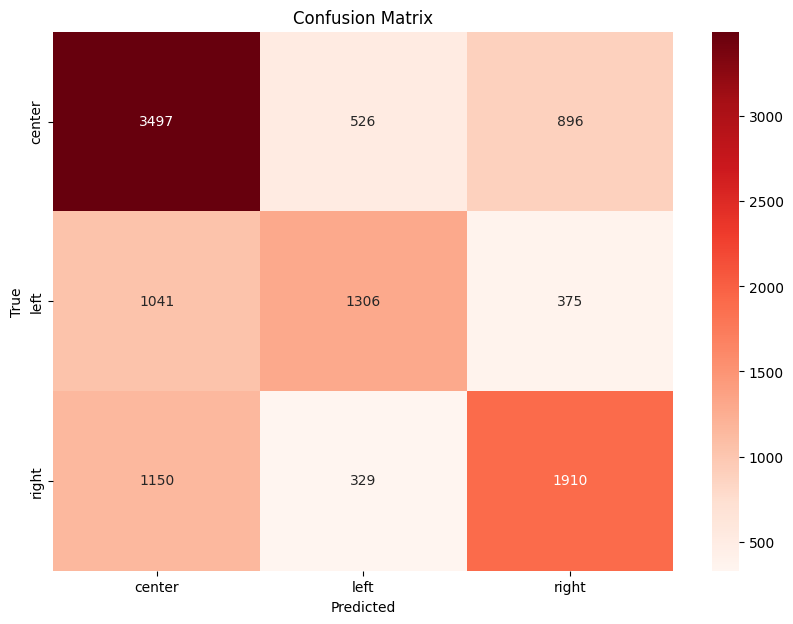

In [8]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
true_labels = test_dataset['label']

cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
print(classification_report(y_test, pred_labels, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

      center       0.61      0.71      0.66      4919
        left       0.60      0.48      0.53      2722
       right       0.60      0.56      0.58      3389

    accuracy                           0.61     11030
   macro avg       0.61      0.58      0.59     11030
weighted avg       0.61      0.61      0.60     11030

